
==================== Checking Layer: ENC1 (30x30) ====================
MSE: 11.655856 | Max Err: 3.686523 | Status: ❌ FAIL


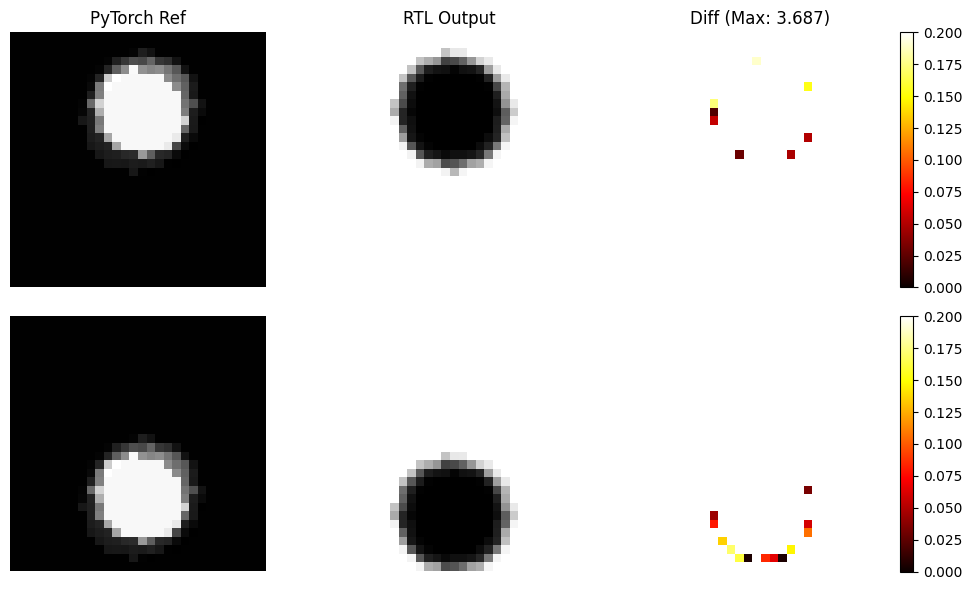


==================== Checking Layer: ENC2 (14x14) ====================
MSE: 8.899762 | Max Err: 6.571289 | Status: ❌ FAIL


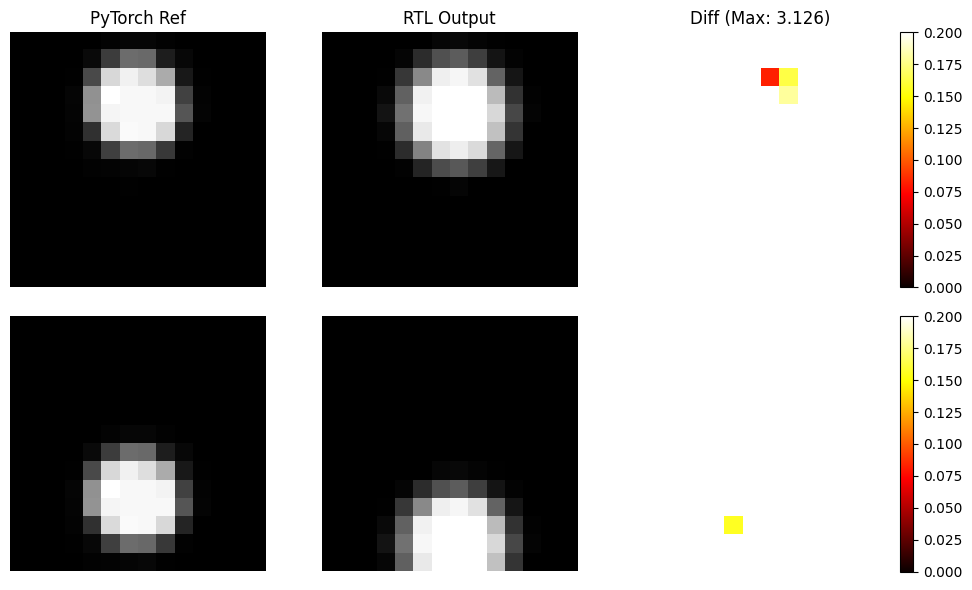


==================== Checking Layer: ENC3 (6x6) ====================
MSE: 5.500632 | Max Err: 9.278320 | Status: ❌ FAIL


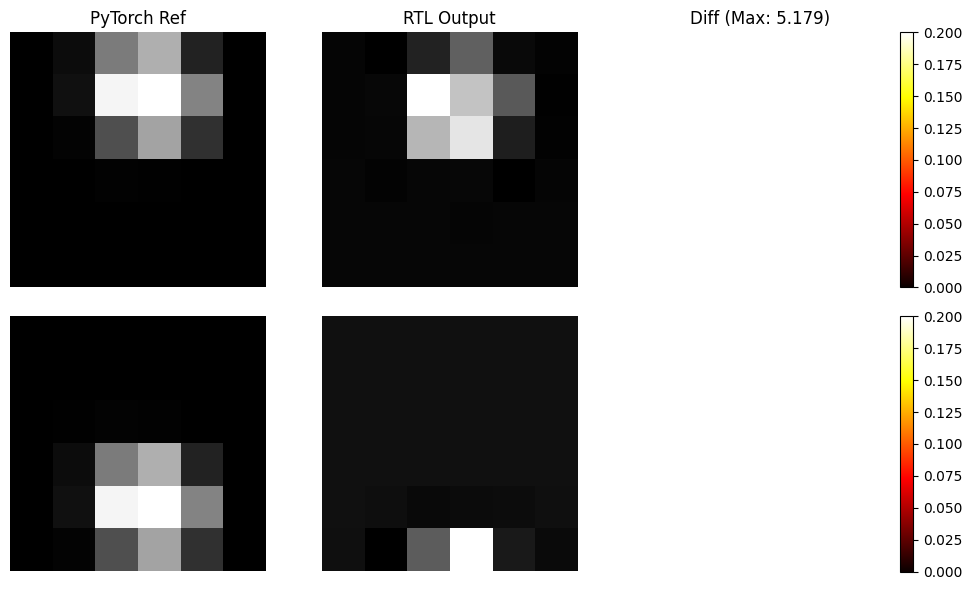


==================== Checking Layer: DEC1 (14x14) ====================
⚠️ ref_dec1.csv: Data kurang (162/392). Padding with 0.
⚠️ rtl_dec1.csv: Data kurang (243/392). Padding with 0.
MSE: 0.992875 | Max Err: 5.834961 | Status: ❌ FAIL


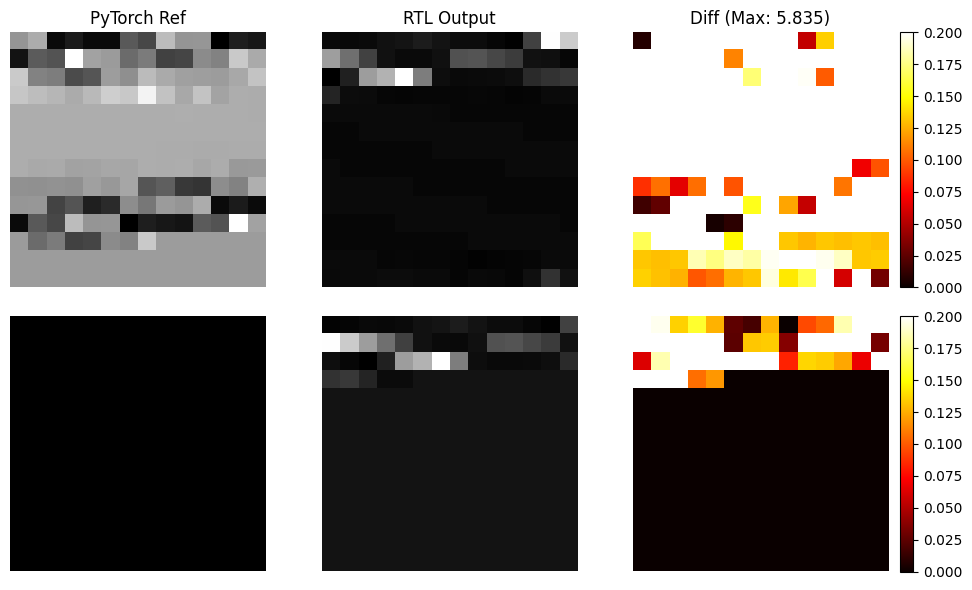


==================== Checking Layer: DEC2 (30x30) ====================
⚠️ ref_dec2.csv: Data kurang (450/1800). Padding with 0.
⚠️ rtl_dec2.csv: Data kurang (748/1800). Padding with 0.
MSE: 0.374478 | Max Err: 3.348633 | Status: ❌ FAIL


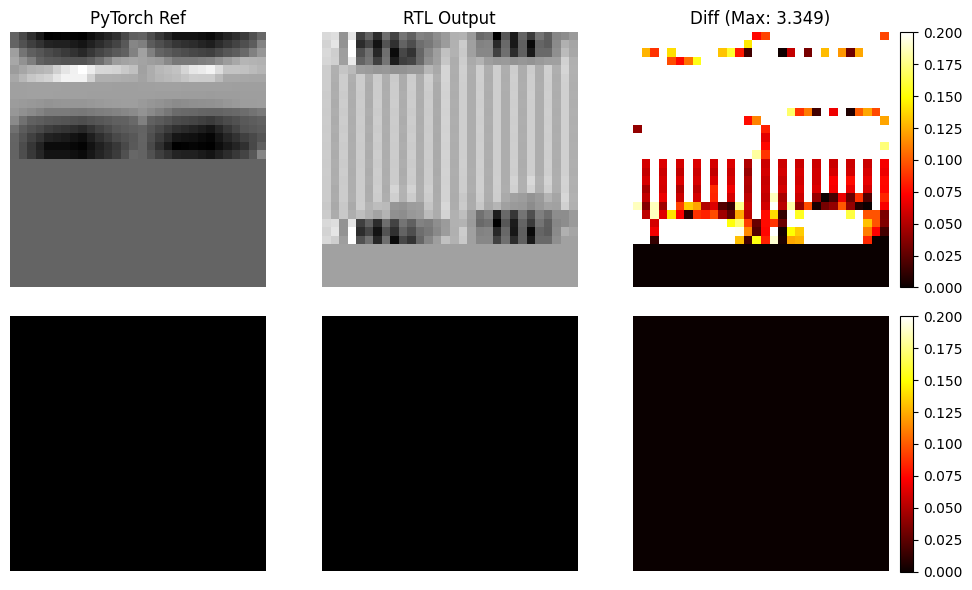


==================== Checking Layer: OUT (28x28) ====================
⚠️ ref_out.csv: Data kurang (338/1568). Padding with 0.
⚠️ rtl_out.csv: Data kurang (622/1568). Padding with 0.
MSE: 0.287928 | Max Err: 1.964844 | Status: ❌ FAIL


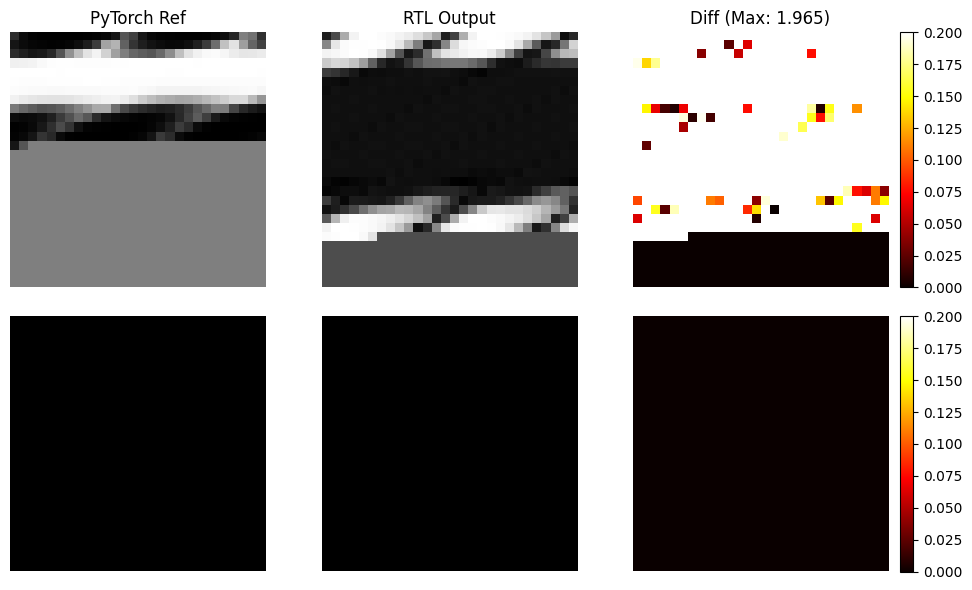

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- CONFIG ---
SCALE = 1024.0
DATA_DIR = "../data/tests/test_v2"
NUM_FRAMES = 2

# Definisi Layer: (Nama, Lebar, Tinggi)
LAYERS = [
    ("enc1", 30, 30),
    ("enc2", 14, 14),
    ("enc3",  6,  6),
    ("dec1", 14, 14),
    ("dec2", 30, 30),
    ("out",  28, 28)
]

def load_data(filename, h, w):
    path = os.path.join(DATA_DIR, filename)
    if not os.path.exists(path):
        print(f"❌ Missing: {filename}")
        return np.zeros((NUM_FRAMES, h, w))
    
    data = np.loadtxt(path, dtype=int)
    expected = NUM_FRAMES * h * w
    
    # Robustness handling
    if len(data) < expected:
        print(f"⚠️ {filename}: Data kurang ({len(data)}/{expected}). Padding with 0.")
        data = np.pad(data, (0, expected - len(data)))
    elif len(data) > expected:
        data = data[:expected]
        
    return data.reshape(NUM_FRAMES, h, w) / SCALE

# --- MAIN LOOP ---
for name, h, w in LAYERS:
    print(f"\n{'='*20} Checking Layer: {name.upper()} ({h}x{w}) {'='*20}")
    
    # Load Ref & RTL
    ref = load_data(f"ref_{name}.csv", h, w)
    rtl = load_data(f"rtl_{name}.csv", h, w)
    
    # Calc Error
    diff = np.abs(ref - rtl)
    mse = np.mean(diff**2)
    max_err = np.max(diff)
    
    status = "✅ PASS" if max_err < 0.1 else "❌ FAIL"
    print(f"MSE: {mse:.6f} | Max Err: {max_err:.6f} | Status: {status}")
    
    # Plotting
    fig, axes = plt.subplots(NUM_FRAMES, 3, figsize=(10, 3 * NUM_FRAMES))
    if NUM_FRAMES == 1: axes = np.expand_dims(axes, 0)
    
    for i in range(NUM_FRAMES):
        # Ref
        ax = axes[i][0]
        ax.imshow(ref[i], cmap='gray')
        if i==0: ax.set_title("PyTorch Ref")
        ax.axis('off')
        
        # RTL
        ax = axes[i][1]
        ax.imshow(rtl[i], cmap='gray')
        if i==0: ax.set_title("RTL Output")
        ax.axis('off')
        
        # Diff
        ax = axes[i][2]
        im = ax.imshow(diff[i], cmap='hot', vmin=0, vmax=0.2)
        if i==0: ax.set_title(f"Diff (Max: {np.max(diff[i]):.3f})")
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
    plt.tight_layout()
    plt.show()